First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 



# Assignment 1


这项任务的目的是了解简单的数据管理实践，并熟悉我们稍后将重用的一些数据。

此笔记本使用[notMNIST]（http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html）数据集与python实验一起使用。 该数据集的设计看起来像经典[MNIST]（http://yann.lecun.com/exdb/mnist/)数据集，而看起来更像真实数据：这是一项更难的任务，
而且这些数据不如MNIST的“干净”。

### 首先导入需要的包

In [8]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### 下载数据到本地

首先，这个作业是2016年Udacity一门课程的作业，作业中给出的原始数据集下载链接早已失效，我用的是自己又重新搜索找到的一个[下载链接](http://yaroslavvb.com/upload/notMNIST/)

建议使用浏览器下载到本地后放到需要的文件夹中，因为我用下面的代码尝试了几次都没有成功

数据由在28x28图像上以各种字体呈现的字符组成。 标签限于'A'到'J'（10个等级）。 训练集大约有500k，测试集是19000个有标签的例子。 鉴于这些尺寸，应该可以在任何机器上快速训练模型。

In [9]:
url = 'http://yaroslavvb.com/upload/notMNIST/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """
  用于报告下载进度的hook。 这主要适用于互联网连接速度较慢的用户。 报告下载进度每次变化5％。
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

In [10]:
def maybe_download(filename, expected_bytes, force=False):
  """
  如果本地不存在数据文件，请下载文件，并确保其大小合适。
  """
  dest_filename = os.path.join(data_root, filename)
  
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


从压缩的.tar.gz文件中提取数据集。 这应该给你一组目录，标记为A到J.

In [11]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1 ：探索数据
---------

让我们看看一些数据，以确保它看起来合理。 每个示例应该是以不同字体呈现的字符A到J的图像。显示我们刚刚下载的图像样本。 提示：您可以使用IPython.display包。

---

对于数据集中的每个字母文件夹，随机的选择其中一个图片并渲染成图像

- 使用`os.listdir()`获取文件夹中的文件列表
- 使用`mpl.image.imread`将图像读入为`ndarray`，并使用`plt.imshow`将`ndarray`渲染成图像

In [14]:
!ls ./notMNIST_large/

A  B  C  D  E  F  G  H	I  J


In [13]:
!ls ./notMNIST_small/

A  B  C  D  E  F  G  H	I  J


In [22]:
characters = 'abcdefghij'.upper() # 
print(characters)
print(type(characters))
image_per_folder = 4 # 每个子文件夹显示的图像数量

ABCDEFGHIJ
<class 'str'>


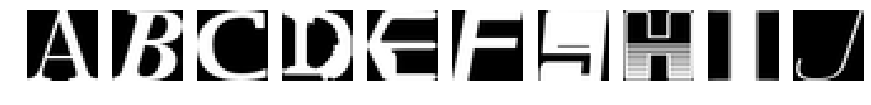

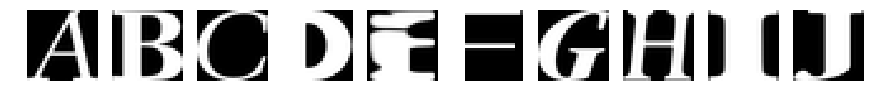

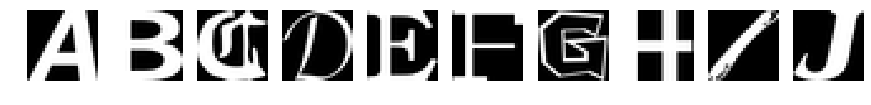

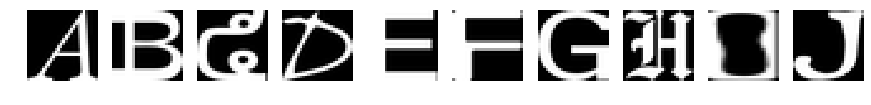

In [27]:
base_path ='./notMNIST_small/'

list_of_images = []

for _ in range(image_per_folder):
    for char in characters:
        char_folder = base_path + char + '/'
        images = os.listdir(char_folder)
        image_file_name = images[np.random.randint(len(images))]
        list_of_images.append(char_folder + image_file_name)
        
def showImagesHorizontally(list_of_files):
    from matplotlib.pyplot import figure,imshow,axis 
    from matplotlib.image import imread 
    
    number_of_files = len(list_of_files)
    num_char = len(characters)
    
    for row in range(int(number_of_files/num_char)):
        fig = figure(figsize=(15,5))
        
        for i in range(num_char):
            a = fig.add_subplot(1, num_char,i+1)
            image = imread(list_of_files[row * num_char + i])
            imshow(image, cmap='gray')
            axis('off')

showImagesHorizontally(list_of_images)

### 数据管理

- 删除不可读图像 
- normalization
- 按字符/文件夹选择正则化之后的数据

现在让我们以更易于管理的格式加载数据。因为，根据计算机设置，可能无法将其全部装入内存，因此我们将每个类加载到一个单独的数据集中，将它们存储在磁盘上并独立地进行策划。 稍后我们将它们合并为一个可管理大小的数据集。

我们将整个数据集转换为浮点值的3D数组（图像索引，x，y），归一化为具有近似零均值和标准偏差〜0.5，以使训练更容易。

一些图像可能无法读取，我们直接跳过它们。

- Normalize image using

`image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth`

In [29]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454492
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Full dataset tensor: (52912, 28, 28)
M

---
Problem 2： 
---------

显示`ndarray`中的标签和图像样本。 提示：您可以使用`matplotlib.pyplot`。

---

### 加载测试数据集并显示每个pickle数据集的标准化图像

- notMNIST_small只是为了在加载所有训练数据时内存不足的问题

- 使用`pickle.load(file_path,'rb')`来加载`pickle`
- 创建一个图像对象，并使用`fig.add_subplot(1,len(images),i+1)`为每个图像添加子图
- 使用`matplotlib.pyplot.imshow(image)`渲染表示的图像

Number of samples in ./notMNIST_small/A.pickle: 1872
Number of samples in ./notMNIST_small/B.pickle: 1873
Number of samples in ./notMNIST_small/C.pickle: 1873
Number of samples in ./notMNIST_small/D.pickle: 1873
Number of samples in ./notMNIST_small/E.pickle: 1873
Number of samples in ./notMNIST_small/F.pickle: 1872
Number of samples in ./notMNIST_small/G.pickle: 1872
Number of samples in ./notMNIST_small/H.pickle: 1872
Number of samples in ./notMNIST_small/I.pickle: 1872
Number of samples in ./notMNIST_small/J.pickle: 1872


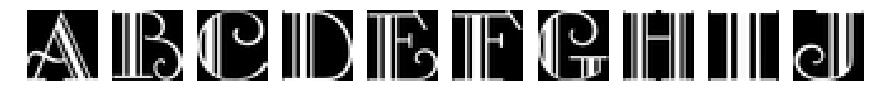

In [33]:
images = []
for file_path in test_datasets:
    data = pickle.load(open(file_path,'rb'))
    print('Number of samples in {}: {}'.format(file_path,data.shape[0]))
    images.append(data[0,:,:])
    
from matplotlib.pyplot import figure,imshow,axis
fig = figure(figsize=(15,5))
for i, image in enumerate(images):
    a = fig.add_subplot(1,len(images), i + 1)
    imshow(image, cmap='gray')
    axis('off')

---
Problem 3
---------
另一项检查：我们希望数据在不同类别之间得到平衡。 下面进行验证。

---

### 检查训练集

在Problem2中，可以看到测试集中数据是平衡的，下面看看在训练集中是什么样子

In [34]:
for file_path in train_datasets: 
    data = pickle.load(open(file_path,'rb'))
    print('Number of samples in {}: {}'.format(file_path,data.shape[0]))

Number of samples in ./notMNIST_large/A.pickle: 52909
Number of samples in ./notMNIST_large/B.pickle: 52911
Number of samples in ./notMNIST_large/C.pickle: 52912
Number of samples in ./notMNIST_large/D.pickle: 52911
Number of samples in ./notMNIST_large/E.pickle: 52912
Number of samples in ./notMNIST_large/F.pickle: 52912
Number of samples in ./notMNIST_large/G.pickle: 52912
Number of samples in ./notMNIST_large/H.pickle: 52912
Number of samples in ./notMNIST_large/I.pickle: 52912
Number of samples in ./notMNIST_large/J.pickle: 52911


很好

### 将单独的字母数据集合并在一起

根据需要合并和修剪训练数据。 根据您的计算机设置，您可能无法将其全部放入内存中，您可以根据需要调整`train_size`。 标签将存储在0到9的单独数组中。

为超参数调整创建验证数据集。 

In [35]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


###   randomize the data

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

- 训练集和测试集应该应用相同的`shuffle`
- 虽然这里只进行了一次随机化，但是当我们多次使用相同的数据集时，可能会多次进行随机化

In [36]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4：完整性检查
---------
Convince yourself that the data is still good after shuffling!

---

In [42]:
lookup_labels = {k: v for (k, v) in zip(np.arange(10),'ABCDEFGHIJ')}
def sanity_check(X, y, s=None):
    print(s)
    m1,m2 = X.shape[0],y.shape[0]
    assert(m1 == m2)
    
    # 随机抽取10张图片检查标签
    indices = np.random.randint(0, m1, size=10)
    
    fig = plt.figure(figsize=(15,5))
    
    for i, idx in enumerate(indices):
        fig.add_subplot(1,len(indices),i+1)
        plt.imshow(X[idx,:,:],cmap = 'gray')
        plt.title(lookup_labels[y[idx]])
        plt.axis('off')

训练集

Training dataset:


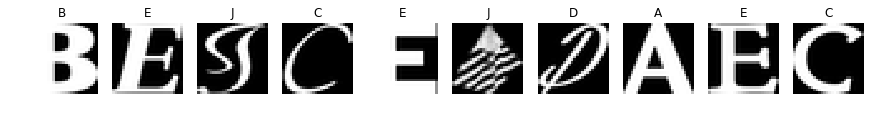

In [43]:
sanity_check(train_dataset,train_labels,'Training dataset:')

测试集

Test dataset:


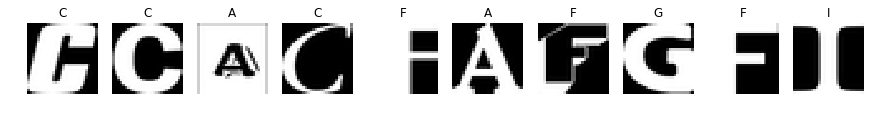

In [44]:
sanity_check(test_dataset,test_labels,'Test dataset:')

序列化数据以供后面使用



In [45]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [46]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5：删除测试集/验证集中的重叠样本
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### Find duplicate images in test set

这里使用余弦相似度来测量训练集中的图像A是否与验证集/测试集中的图像B相同

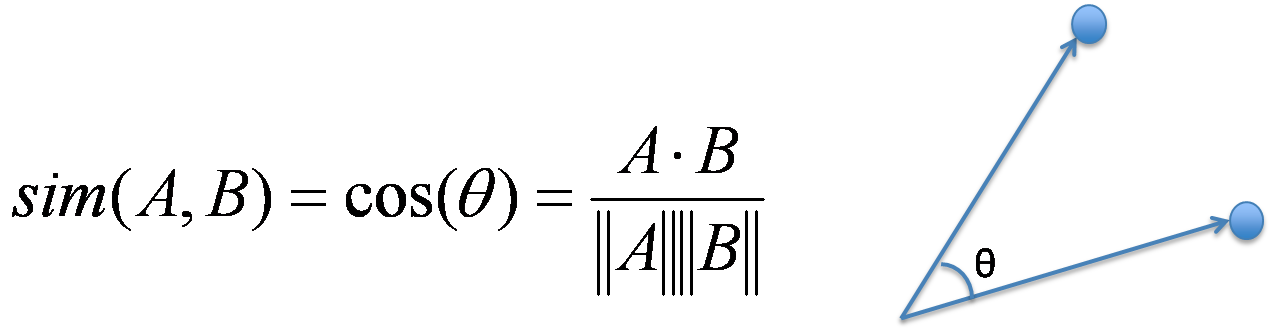

如公式所示，
- 将训练集中的每个图像重新`reshape`为列向量，并对验证集/测试集中的图像执行相同操作，并计算向量之间的相似性。 
- 虽然可以具体地计算每个`(train image vector, test image vector)`的余弦相似度，但最好使用向量化来加速计算

关键点：

- 使用`cosine_sim = np.inner（X，Y）/ np.inner（np.abs（X），np.abs（Y））`对训练集/测试集图像进行向量化并计算余弦相似度
- 输出矩阵`cosine_sim`的形状是`（m1，m2）`，其中`m1`是训练集图像的数量，`m2`是测试集图像的数量

- `cosine_matrix（i，j）`表示训练集图像`#i`和测试集图像`#j`之间的余弦相似度 


Number of duplicates in test dataset: 1757
CPU times: user 1min 26s, sys: 30.8 s, total: 1min 57s
Wall time: 8min 55s


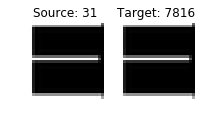

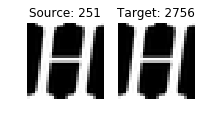

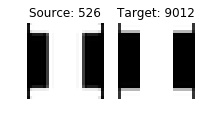

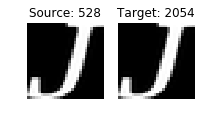

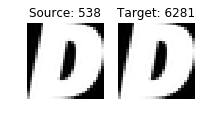

In [47]:
import time
%%time
def get_duplicate_data(source_dataset, target_dataset, threshold=1, num_duplicate_to_show=0):
    
    X = source_dataset.reshape(source_dataset.shape[0], -1)
    Y = target_dataset.reshape(target_dataset.shape[0], -1)
    assert(X.shape[1] == Y.shape[1])
    
    dim = X.shape[1]
    cosine_sim = np.inner(X, Y) / np.inner(np.abs(X), np.abs(Y))
    assert(cosine_sim.shape == (X.shape[0], Y.shape[0]))
    
    # for each image in training set, find corresponding duplicate in test/valid set
    dup_target_indices = []
    show_duplicate_counter = 0
    for source_idx in range(cosine_sim.shape[0]):
        dup_indices = list(np.where(cosine_sim[source_idx, :] >= threshold)[0])
    
        # render duplicate images when is available. may omit if visual output is not required
        if dup_indices and num_duplicate_to_show and (show_duplicate_counter < num_duplicate_to_show):
            # show only non-redudent duplicate images
            for i in dup_indices:
                if i in dup_target_indices:
                    dup_indices.remove(i)
            if not dup_indices: continue
            
            if len(dup_indices) == 1:
            
                fig = plt.figure(figsize=(3, 15))
                fig.add_subplot(1, len(dup_indices) + 1, 1)
                plt.imshow(source_dataset[source_idx, :, :], cmap='gray')
                plt.title('Source: ' + str(source_idx))
                plt.axis('off')
            
            
                for i, target_idx in enumerate(dup_indices):
                    fig.add_subplot(1, len(dup_indices) + 1, i + 2)
                    plt.imshow(target_dataset[target_idx, :, :], cmap='gray')
                    plt.title('Target: ' + str(target_idx))
                    plt.axis('off')

                show_duplicate_counter += 1
        
        dup_target_indices.extend(dup_indices)
    return list(set(dup_target_indices))
        
    
dup_indices_test = get_duplicate_data(train_dataset, test_dataset, num_duplicate_to_show=5)
print('Number of duplicates in test dataset: {}'.format(len(dup_indices_test)))

### Find duplicate images in validation set

Number of duplicates in validation dataset: 1479
CPU times: user 1min 30s, sys: 42.3 s, total: 2min 12s
Wall time: 6min 51s


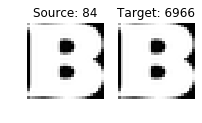

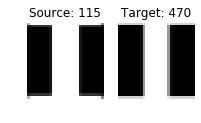

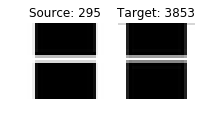

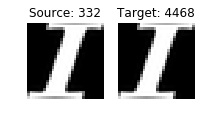

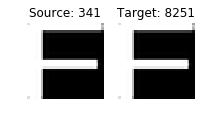

In [48]:
%%time
dup_indices_valid = get_duplicate_data(train_dataset, valid_dataset, num_duplicate_to_show=5)
print('Number of duplicates in validation dataset: {}'.format(len(dup_indices_valid)))

### Serialize sanitized dataset for later model performance comparison


  - Remove duplicates in test/valid set
  - Save dataset


Do the same operation to both X and y

In [49]:
print("Number of duplicate images in test set: {}".format(len(dup_indices_test)))
print("Number of duplicate images in valid set: {}".format(len(dup_indices_valid)))

Number of duplicate images in test set: 1757
Number of duplicate images in valid set: 1479


In [50]:
non_duplicate_indices = [i for i in range(test_dataset.shape[0]) if not i in dup_indices_test]
sanitized_test_dataset = test_dataset[non_duplicate_indices, :, :]
sanitized_test_labels = test_labels[non_duplicate_indices]

non_duplicate_indices = [i for i in range(valid_dataset.shape[0]) if not i in dup_indices_valid]
sanitized_valid_dataset = valid_dataset[non_duplicate_indices, :, :]
sanitized_valid_labels = valid_labels[non_duplicate_indices]

In [51]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': sanitized_valid_dataset,
    'valid_labels': sanitized_valid_labels,
    'test_dataset': sanitized_test_dataset,
    'test_labels': sanitized_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [52]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 680639472


---
Problem 6: LogisticRegression
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
np.random.seed(42)
train_sizes = [100, 1000, 50000, 100000, 200000]

In [54]:
# train models using different size of training set
test_scores, test_scores_sanitized = [[] for _ in range(2)]
for train_size in train_sizes:
    # random choose #train_size of training instances
    indices = np.random.randint(0, train_dataset.shape[0], train_size)
    
    # reshape images to (train_size, dim * dim) for easier processing
    X = train_dataset[indices, :, :]\
        .reshape(-1, train_dataset.shape[1] * train_dataset.shape[2])
    y = train_labels[indices]
        
    # train model
    clf = (LogisticRegression(random_state=10, solver='lbfgs', multi_class='multinomial')
                  .fit(X, y))
    
    # test on original test set and the sanitized one
    y_pred = clf.predict(test_dataset.reshape(test_dataset.shape[0], -1))
    y_pred_sanitized = clf.predict(sanitized_test_dataset.reshape(sanitized_test_dataset.shape[0], -1))

    test_score = accuracy_score(y_pred, test_labels)
    test_score_sanitized = accuracy_score(y_pred_sanitized, sanitized_test_labels)
    test_scores.append(test_score)
    test_scores_sanitized.append(test_score_sanitized)

/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

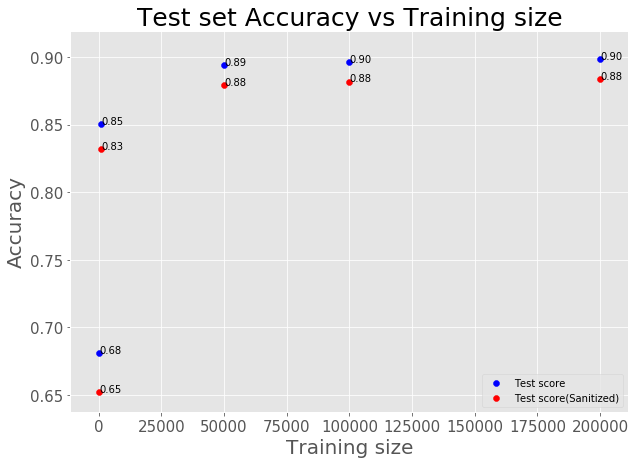

In [56]:
plt.figure(figsize=(10, 7))
plt.xlabel('Training size', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for x, y in zip(train_sizes, test_scores):
    plt.text(x + 50, y, '{:.2f}'.format(y))
for x, y in zip(train_sizes, test_scores_sanitized):
    plt.text(x + 50, y, '{:.2f}'.format(y))
    
plt.scatter(train_sizes, test_scores, label='Test score', color='blue');
plt.scatter(train_sizes, test_scores_sanitized, label='Test score(Sanitized)', color='red');
plt.legend(loc=4)
plt.title('Test set Accuracy vs Training size', fontsize=25);

- 通过在训练阶段使用更多数据，模型在测试集中的分类效果更好。 通过在所有可用的训练数据上训练简单的逻辑回归模型，可以获得大约90％的准确度。

- 具有重复图像的测试集与没有重复图像的测试集之间存在性能差异（精度为2~3％）。取决于我们的应用程序，选择最适合我们用例的应用程序。

- 在这个笔记本中只是为了快速走完一个完整的机器学习流程，获得一个可用的模型，没有使用验证集来调整超参数。 

- 可以通过调整超参数或在另一个笔记本中使用神经网络来进一步提高模型的预测性能。